# Data Programming in Python, Coursework 1

## Data Science Job Trends Project

### Project Description and Purpose

In this project, job postings in the field of data science are compared in terms of various filters in 4 different countries where the daily spoken language is English, by applying data analysis methods on the data that taken from LinkedIn.

With this project, job postings in the field of data analysis published on LinkedIn in the USA, UK, Canada and Australia;

- Job type (full-time, part-time, internship etc.)
- Job function (engineering, information technology, science etc.)
- Business industry (IT services, financial services, management consulting etc.)
- Work level (entry level, director, mid-senior level etc.)
- Work location
- Salary information
- Employer institution,

it is aimed to enable to apply for a job with a deep comparison, taking into account all of the variables.


### Methods

First of all, it was decided to work with about 550 pieces of data including salary information in order to perform a consistent analysis. The HTML document structure of the job postings listed on the LinkedIn job search page was examined and the content of the relevant html elements containing the information about the postings was scraped and extracted. Later, this information was converted into a CSV file.

**The page for searching job postings in LinkedIn.com:**

---

![The page for searching job postings in LinkedIn.com](search-page.jpeg)

---

Transformations and cell filling processes were performed on the missing data in the CSV file. Necessary preparation processes have been completed in order to make the data set suitable for analysis.
Finally, in the analysis phase, some statistical inferences, tables containing the relationships between the variables, some graphical visualizations were made in order to make the comparisons understandable and to draw attention to the important concepts in the job descriptions.

Basic application steps of the methods: 
- Web scraping 
- Data cleaning 
- Exploratory data analysis


All these processes were carried out with the python programming language and basically the following libraries were used:
- BeautifulSoup (to extract data via web scraping by parsing LinkedIn HTML clauses)
- Pandas (for data reading, data preprocessing and data cleaning)
- Numpy (for mathematical operations and statistical inferences)
- Matplotlib (to plot graphs to compare the filters and visualize data)
- Seaborn (to plot graphs to compare the filters and visualize data)
- NLTK (to process job description text)

*Note: Before starting the coursework, an e-mail was sent to the LinkedIn officials in order to get the necessary permissions. After a 1 week waiting period, the web scraping process was started since the coursework delivery date was approaching.*

**The email to ask for permission of crawling:**

---

![The email to ask for permission of crawling](email.jpeg)

---

In [62]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import re
from matplotlib import pyplot as plt
import nltk
from wordcloud import WordCloud
from nltk.collocations import *
import plotly.express as px
import seaborn as sns
import os.path
from nltk.corpus import stopwords
import plotly.express as px
from nltk.util import everygrams

## Load

Below, the latest version of the CSV file that stores the job opening records is being loaded into a `DataFrame` object. If there is no file stored yet, an empty `DataFrame` object is created.

In [3]:
if os.path.isfile("jobs.csv"):
    df = pd.read_csv("jobs.csv", index_col=False, na_values=[""])
else:
    df = pd.DataFrame(columns=["job_id"])

df["job_id"] = df["job_id"].astype(int)

## Scraping

In this section, the data is being scraped from `LinkedIn.com`'s job searching page using HTML parsing methods. The search page is presented in multiple pages, so the request should be sent for multiple times to fetch all the pages. Also, it is better to search the records for multiple keywords sequentally, so it would be possible to reach a wider range of data, which is applicable also for multiple countries.

Below, the `User-Agent` header is being defined to be passed while sending the HTTP request to get the list of the job openings and to get the details of them.

In [201]:
headers = {
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36",
}

Parameters for different geographical locations and different keywords to search the jobs for are defined below. They will be crossed over by each others to be able to fetch more data.

In [202]:
geoids = {
    "United States": "103644278",
    "United Kingdom": "101165590",
    "Canada": "101174742",
    "Australia": "101452733",
}
keywords = [
    "Data Scientist",
    "Data Analyst",
    "Data Engineer",
]

Scrapping job listing pages from `LinkedIn.com` page by page (each page has 25 record) per each country and keyword. The HTML document that is responded to the request is being parsed as `BeautifulSoup` object, and added into the `pages` list to be processed later.

In [ ]:
pages = []
for start in range(0, 1000, 25): # start variable specifies the offset of the records to fetch. It must increase by 25 for each page
    for country, geoid in geoids.items(): # Iterating entries of geoids dictionary as tuples of key-value pairs
        for keyword in keywords:
            print("Scraping start={}, country={}, keyword={}".format(start, country, keyword))
            while True:
                try:
                    res = requests.get(
                        # Building the URL to send the request for, using the keyword and geoId pairs
                        "https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords={}&geoId={}&trk=public_jobs_jobs-search-bar_search-submit&start={}".format(keyword, geoid, start),
                        headers=headers,
                        timeout=2,
                    )
                    if res.status_code == 200: # If the status code is 200, there is no error, so the HTML can be parsed
                        document = BeautifulSoup(res.text, "html.parser")
                        pages.append({
                            # Instead of adding the document directly to the list, it is better to store also the country together the document
                            "document": document,
                            "country": country,
                        })
                        break # After parsing the HTML, breaking the most inner loop
                    # If the status code is not 200, then this means there is a problem with the response...
                except Exception as error: # ... or if there is an error with the request itself...
                    # ... then it is only printing a message and letting the loop go to the head after waiting 5 seconds
                    print("An error has occurred, retrying in 5 seconds")
                
                time.sleep(5)

After having 40 page documents *(`LinkedIn.com` doesn't provide information older than last 1000 records for the same parameters)* per each combination of countries and keywords, *which makes 480 at the total*, each of the page document is being processed to extract the provisional information of the job openings. Then, provisional information of the job openings will be used to filter out jobs that are already scrapped and in the `DataFrame` object and to filter out also the jobs with no salary information (only a small part of the job openings has the salary information).

One more HTTP request will be sent to fetch detailed information for each of the rest of the records that are filtered. This follow up HTTP request provides more data like the description, industry, position etc.

Sometimes, `LinkedIn.com` rejects to respond to the request if more than a number of allowed requests have been sent. In this case, it is required to wait for a small period of time between the requests.

In [ ]:
for page in pages:
    document = page["document"]
    country = page["country"]
    # Every record of job openigs are presented in <li> elements
    li_elements = document.find_all(name="li")
    for li_element in li_elements:
        try:
            row = {}

            # In the corresponding <li> element, there is another element with the class "job-search-card",
            #  and this element contains an attribute named "data-entity-urn" which has a value unique per
            #  job opening. It will be used to identify the record.
            card_element = li_element.find(class_="job-search-card")
            data_entity_urn = card_element.attrs["data-entity-urn"].split(":")
            # The part after the last ":" character in data_entity_urn is the id of the record that will
            #  be required to fetch the detailed information.
            job_id = int(data_entity_urn[-1])
            row["job_id"] = job_id

            # If the information of the record with the job id is already scrapped, seek to the next one.
            if (df["job_id"] == job_id).any():
                print("Job #{} is already scraped, skipping".format(job_id))
                continue
            
            # There is an element collapsed by the <li> element, with the class "job-search-card__salary-info".
            #  This element has the salary information for the record. If it is not present, than there is no
            #  salary information is given for the job opening. It should be skipped.
            salary_element = li_element.find(class_="job-search-card__salary-info")
            if salary_element is None:
                print("Job #{} has no salary info, skipping".format(job_id))
                continue

            print("Job #{} is being scraped...".format(job_id))

            # There are elements in the <li> element being processed contains some specific information of
            #  the job opening. These elements have following classes:
            #  - base-search-card__title
            #  - base-search-card__subtitle
            #  - job-search-card__listdate or job-search-card__listdate--new
            #  - job-search-card__location

            title_element = li_element.find(class_="base-search-card__title")
            title = title_element.text.strip()
            row["title"] = title
            
            subtitle_element = li_element.find(class_="base-search-card__subtitle")
            subtitle = subtitle_element.text.strip()
            row["subtitle"] = subtitle

            salary = salary_element.text.strip()
            row["salary"] = salary

            listdate_element = li_element.find(class_="job-search-card__listdate")
            if listdate_element is None:
                listdate_element = li_element.find(class_="job-search-card__listdate--new")
            listdate = listdate_element.attrs["datetime"]
            row["list_date"] = listdate

            location_element = li_element.find(class_="job-search-card__location")
            location = location_element.text.strip()
            row["location"] = location

            row["country"] = country
        except Exception as error:
            # If an error occurs while parsing the document, this means the document is corrupted or
            #  the schema has been changed. So it cannot be recovered and should be skipped.
            print("An error has occurred while parsing the list document, skipping the job")
            continue
            
        while True:
            try:
                # To have more detailed information related to the record, it is required to
                #  send another HTTP request with the job id to fetch the data.
                res = requests.get(
                    "https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{}".format(job_id),
                    headers=headers,
                    timeout=2,
                )
                if res.status_code == 200:
                    details_document = BeautifulSoup(res.text)
                    break
            except Exception as error:
                print("An error has occurred while requesting the job document, retrying in 5 seconds")
            
            time.sleep(5)
        
        try:
            # The element with the class "show-more-less-html__markup" in the document contains
            #  the description of the job opening.
            description_element = details_document.find(class_="show-more-less-html__markup")
            description = description_element.get_text(separator="\n").strip()
            row["description"] = description

            # There are a few more elements for other data in the document. These elements has no
            #  specific classes to identify them but a class that is common for all of them, "description__job-criteria-item".
            #  The element with the class "description__job-criteria-subheader" contains the label of
            #  the data while the lemenet with the class "description__job-criteria-text" contains the
            #  value of the same data.
            criteria_elements = details_document.find_all(class_="description__job-criteria-item")
            for criteria_element in criteria_elements:
                criteria_subheader_element = criteria_element.find(class_="description__job-criteria-subheader")
                criteria_subheader = criteria_subheader_element.text.strip()
                criteria_subheader = str.lower(criteria_subheader).replace(" ", "_")
                criteria_text_element = criteria_element.find(class_="description__job-criteria-text")
                criteria_text = criteria_text_element.text.strip()
                # Each of these information is being stored in the row with the column named the same label.
                row[criteria_subheader] = criteria_text

            # After processing each record, it is better to save the row to the existing DataFrame and save it to
            #  the CSV file. Note: To avoid writing index columns in the CSV file, index=False is required.
            df = df.append(row, ignore_index=True)
            df.to_csv("jobs.csv", index=False)
        except Exception as error:
            print("An error has occurred while parsing the job document, skipping the job")
            time.sleep(5)

## Cleaning

In this section, the scraped data will be preprocessed. By proceprocessing, it is meant to remove or replace NaN and empty values, to convert different units of salaries into a common one (£ is choosen as the base unit in the case) and to filter out rows with extremely high/low values.

The first thing to do is to replace unspecified values under "industries" column with the one used most frequently.

In [4]:
top_industries = df['industries'].mode()[0]
df['industries'] = df['industries'].fillna(top_industries)

Then unspecified values under "job_function" column is being replaced with the one used most frequently.

In [5]:
top_job_functions = df['job_function'].mode()[0]
df['job_function'] = df['job_function'].fillna(top_job_functions)

Only cells with missing data in the "industries" and "job_function" columns were filled because filling in other columns could cause the dataset to be biased. (For example, filling in the cell matching low salary data in the "seniority_level" column with a senior position 'director')


The salary information is given in a single column that contains the minimum and maximum range as two numbers separated by a "-" character and prefixed by the currency symbol. (Example: `$30,000.00 - $60,000.00`)

To be able to process the salary information, it is required to parse these values as separate floating point number values, without losing the currency information. To do this, the value in each "salary" column is simply being splitted at "-" characters into two parts just after removing any characters that are not digits, "-" character nor "." character. And these two parts are being converted into numeric values as separate columns named "salary_min" and "salary_max".

In [6]:
salary = df['salary'].apply(lambda x: re.sub(r"[^\d\.\-]", "", x))
df["salary_min"] = pd.to_numeric(salary.apply(lambda x: x.split("-")[0] if x!="" else ""))
df["salary_max"] = pd.to_numeric(salary.apply(lambda x: x.split("-")[1] if x!="" else ""))

As it is also required to extract the currency information, the currency information is being separated from the values in "salary" column. To do this, the salary string is simply separated at the first digit character and the first part is taken by the currency symbol.

In [7]:
df["salary_unit"] = df['salary'].apply(lambda x: re.split(r"[\d]+", x)[0] if x!="" else "")

The salary information in the job opening records are presented in following currencies:
- £ - British Pound
- $ - US Dollars
- € - Euro
- CA$ - Canadian Dollars
- A$ - Australian Dollars

To have a better comparision between the salaries in different currencies, it is better to convert them into a convertible common unit. For doing this, British Pound (£) is choosen as the base unit and all other values are converted into this by multiplying the relevant exchange rate.

*Note: The rates are collected from Google on 2nd of January 2022.*

In [8]:
# Exchange rates are defined in a dictionary that has the currency symbols as the keys and exchange rates (to British Pound) as the values.
exchange_rates = {
    "£": 1,
    "$": 0.74,
    "€": 0.84,
    "CA$": 0.58,
    "A$": 0.54,
}

# "salary_min" and "salary_max" columns are being multiplied by exchange rate of the related unit.
df["norm_salary_min"] = df.apply(lambda row: row["salary_min"] * exchange_rates[row["salary_unit"]], axis=1)
df["norm_salary_max"] = df.apply(lambda row: row["salary_max"] * exchange_rates[row["salary_unit"]], axis=1)

# Calculating the average of min and max values of the salary range specified in the record.
df["norm_salary_average"] = (df["norm_salary_min"] + df["norm_salary_max"]) / 2

df

,job_id,employment_type,industries,job_function,seniority_level,country,description,list_date,location,salary,subtitle,title,salary_min,salary_max,salary_unit,norm_salary_min,norm_salary_max,norm_salary_average
0,2852686232,Full-time,Financial Services,"Engineering, Information Technology, and Finance",Entry level,United Kingdom,We looking for a talented graduate to join our...,2021-12-27,United Kingdom,"$30,000.00 - $30,000.00",Mosaic Smart Data,Mosaic Graduate Programme,30000.00,30000.00,$,22200.0000,22200.0000,22200.0000
1,2848989561,Full-time,Staffing and Recruiting,Engineering and Information Technology,Entry level,United Kingdom,Junior Data Scientist\nBurns Sheehan \n London...,2021-12-22,"London, England, United Kingdom","£40,000.00 - £65,000.00",Burns Sheehan,Junior Data Scientist,40000.00,65000.00,£,40000.0000,65000.0000,52500.0000
2,2849475648,Full-time,Staffing and Recruiting,Information Technology,NaN,Canada,Looking for a rewarding career change? Join ou...,2021-12-22,"Thunder Bay, Ontario, Canada","CA$65,936.88 - CA$65,936.88",The District of Thunder Bay Social Services Ad...,Data & Research Analyst,65936.88,65936.88,CA$,38243.3904,38243.3904,38243.3904
3,2848294437,Full-time,Staffing and Recruiting,Information Technology,NaN,Canada,Invico Capital Corporation (“Invico”) is an aw...,2021-12-22,"Calgary, Alberta, Canada","CA$40,000.00 - CA$40,000.00",Invico Capital Corporation,Data Entry Specialist,40000.00,40000.00,CA$,23200.0000,23200.0000,23200.0000
4,2856223096,Full-time,Staffing and Recruiting,Information Technology,NaN,United States,Overview\nMedici Road is a Community Developme...,2021-12-26,"Washington, DC","$60,000.00 - $75,000.00",Medici Road,Research And Policy Analyst,60000.00,75000.00,$,44400.0000,55500.0000,49950.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2825709578,Full-time,"IT Services and IT Consulting, Software Develo...","Information Technology, Analyst, and General B...",Mid-Senior level,Australia,About My Client:\nMy client is an Australian T...,2021-12-09,"Sydney, New South Wales, Australia","$90,000.00 - $110,000.00",White Bay,"Junior Business Analyst - $110,000 + Super!",90000.00,110000.00,$,66600.0000,81400.0000,74000.0000
518,2825712846,Full-time,"IT Services and IT Consulting, Software Develo...","Project Management, Information Technology, an...",Mid-Senior level,Australia,About My Client:\nMy client is a talented comb...,2021-12-09,"Melbourne, Victoria, Australia","A$100,000.00 - A$120,000.00",White Bay,"Junior Business Analyst ($110,000 + Super!)",100000.00,120000.00,A$,54000.0000,64800.0000,59400.0000
519,2793853784,Full-time,Armed Forces,Engineering,Mid-Senior level,Australia,An entry requirement for employment with the A...,2021-11-30,"New South Wales, Australia","A$35,000.00 - A$54,999.00",Australian Army,Aerospace Software Engineer (Undergraduate),35000.00,54999.00,A$,18900.0000,29699.4600,24299.7300
520,2830175860,Full-time,IT Services and IT Consulting,Information Technology,Mid-Senior level,Australia,Rapidly growing Managed Service Provider seeki...,2021-12-07,"Adelaide, South Australia, Australia","A$60,000.00 - A$85,000.00",Redwolf + Rosch,System Engineer,60000.00,85000.00,A$,32400.0000,45900.0000,39150.0000


Another thing that can be done to clean the data is to remove extremely low and extremely high values. In this case, salaries can have extreme values, by removing the rows with such values can improve the processing the data. Upper and lower quartiles can be used as the boundaries that are accepted as the nominal range of the salary.

Before proceeding with the next step, it would be nice to see the extreme values visually:

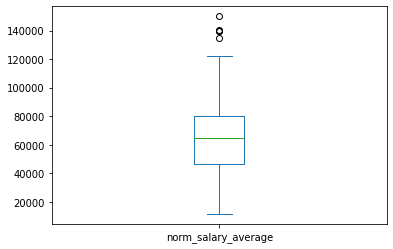

In [9]:
df['norm_salary_average'].plot(kind='box')
None

In [10]:
Q1 = df['norm_salary_average'].quantile(0.25)
Q3 = df['norm_salary_average'].quantile(0.75)
IQR = Q3 - Q1

(Q1, Q3, IQR)

(46287.5, 80000.0, 33712.5)

In [11]:
df = df.drop(df[
    (df['norm_salary_average'] < Q1 - 1.5* IQR)
    |
    (df['norm_salary_average'] > Q3 + 1.5* IQR)
].index)
df

,job_id,employment_type,industries,job_function,seniority_level,country,description,list_date,location,salary,subtitle,title,salary_min,salary_max,salary_unit,norm_salary_min,norm_salary_max,norm_salary_average
0,2852686232,Full-time,Financial Services,"Engineering, Information Technology, and Finance",Entry level,United Kingdom,We looking for a talented graduate to join our...,2021-12-27,United Kingdom,"$30,000.00 - $30,000.00",Mosaic Smart Data,Mosaic Graduate Programme,30000.00,30000.00,$,22200.0000,22200.0000,22200.0000
1,2848989561,Full-time,Staffing and Recruiting,Engineering and Information Technology,Entry level,United Kingdom,Junior Data Scientist\nBurns Sheehan \n London...,2021-12-22,"London, England, United Kingdom","£40,000.00 - £65,000.00",Burns Sheehan,Junior Data Scientist,40000.00,65000.00,£,40000.0000,65000.0000,52500.0000
2,2849475648,Full-time,Staffing and Recruiting,Information Technology,NaN,Canada,Looking for a rewarding career change? Join ou...,2021-12-22,"Thunder Bay, Ontario, Canada","CA$65,936.88 - CA$65,936.88",The District of Thunder Bay Social Services Ad...,Data & Research Analyst,65936.88,65936.88,CA$,38243.3904,38243.3904,38243.3904
3,2848294437,Full-time,Staffing and Recruiting,Information Technology,NaN,Canada,Invico Capital Corporation (“Invico”) is an aw...,2021-12-22,"Calgary, Alberta, Canada","CA$40,000.00 - CA$40,000.00",Invico Capital Corporation,Data Entry Specialist,40000.00,40000.00,CA$,23200.0000,23200.0000,23200.0000
4,2856223096,Full-time,Staffing and Recruiting,Information Technology,NaN,United States,Overview\nMedici Road is a Community Developme...,2021-12-26,"Washington, DC","$60,000.00 - $75,000.00",Medici Road,Research And Policy Analyst,60000.00,75000.00,$,44400.0000,55500.0000,49950.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2825709578,Full-time,"IT Services and IT Consulting, Software Develo...","Information Technology, Analyst, and General B...",Mid-Senior level,Australia,About My Client:\nMy client is an Australian T...,2021-12-09,"Sydney, New South Wales, Australia","$90,000.00 - $110,000.00",White Bay,"Junior Business Analyst - $110,000 + Super!",90000.00,110000.00,$,66600.0000,81400.0000,74000.0000
518,2825712846,Full-time,"IT Services and IT Consulting, Software Develo...","Project Management, Information Technology, an...",Mid-Senior level,Australia,About My Client:\nMy client is a talented comb...,2021-12-09,"Melbourne, Victoria, Australia","A$100,000.00 - A$120,000.00",White Bay,"Junior Business Analyst ($110,000 + Super!)",100000.00,120000.00,A$,54000.0000,64800.0000,59400.0000
519,2793853784,Full-time,Armed Forces,Engineering,Mid-Senior level,Australia,An entry requirement for employment with the A...,2021-11-30,"New South Wales, Australia","A$35,000.00 - A$54,999.00",Australian Army,Aerospace Software Engineer (Undergraduate),35000.00,54999.00,A$,18900.0000,29699.4600,24299.7300
520,2830175860,Full-time,IT Services and IT Consulting,Information Technology,Mid-Senior level,Australia,Rapidly growing Managed Service Provider seeki...,2021-12-07,"Adelaide, South Australia, Australia","A$60,000.00 - A$85,000.00",Redwolf + Rosch,System Engineer,60000.00,85000.00,A$,32400.0000,45900.0000,39150.0000


## Exploratory Data Analysis

In this section, a few different visualizations are applied to the data cleaned in the previous section, to have a comparative insight into it. Bar charts, pie charts, tree maps, heat maps and wordclouds are used for such visualizations.

Below, creating a new column named "location_parts" by processing values of the "location" column. Values in the "location_parts" column should be arrays of parts of addresses. They should be ordered as from the most general to the least.
Example: `["United Kingdom", "England", "London"]`
The "location_parts" column will be used while visualizing the data in the tree maps.

In [12]:
# List's reverse method is not suitible to be used in lambda functions, so it is better to wrap it up.
def reverse_list(list):
    list.reverse()
    return list

# Splitting location value, which is a string, at where ", " is found, and reversing the array to make
#  the more general part of the address comes first.
df["location_parts"] = df["location"].apply(lambda x: reverse_list(x.split(', ')))

# Add country to the head of "location_parts" if there is no present.
df["location_parts"] = df.apply(lambda row: [row["country"], *row["location_parts"]] if row["location_parts"][0] != row["country"] else row["location_parts"], axis=1)

After having properly processed "location_parts" column, it is possible to visualize the data in tree map that is grouped by the location. The tree map will be formed in nested boxes, each box represents an address area. The most general address will be the most parent box, while the most specific address's box will be the most nested one.

Also, the color of each box will represent the average salary in the address that the box specifies.

In [13]:
df_map = df.copy() # Before working on the DataFrame, it is better to create a copy of the original one
# The maximum depth of the nesting will be 3 since the location data have 3 parts at most in our data.
#  To have an easier way of working with the nested groups, it is better to extract the groups into separate columns.
#  As an example, assume that we have the location as "United Kingdom, England, London", so the "country" column should
#  has the value "United Kindom", while the "location_1" column has "England" and the "location_2" column has "London"
#  as their values. If any of these columns is lack of the data, "Not Specified" will be used to fill.
df_map["location_1"] = df_map["location_parts"].apply(lambda x: x[1] if len(x) >= 2 else "Not Specified")
df_map["location_2"] = df_map["location_parts"].apply(lambda x: x[2] if len(x) >= 3 else "Not Specified")
# Taking only the necessary columns
df_map = df_map[["country", "location_1", "location_2", "norm_salary_average", "job_id"]]
# Grouping the rows by the location data and aggregating to have the count and salary information per each groups.
df_map = df_map.groupby(["country", "location_1", "location_2"]).agg(Count=("job_id", "count"), Salary=("norm_salary_average", "mean"))
# Since "agg" method returns a DataFrame with grouping columns as its indices, it is required to make these indices column again.
df_map = df_map.reset_index()

fig = px.treemap(df_map, values="Count", path=["country", "location_1", "location_2"], color="Salary")
fig.show()

According to the graph, the highest number of job postings in the UK is in London, in the USA it is in New York, in Australia it is in Sydney and in Canada it is in Ontario.

Describing the salary information to have an onverview before proceeding with the next steps of visualizations.

In [14]:
df[["norm_salary_average"]].describe()

,norm_salary_average
count,517.000000
mean,63983.938801
std,22256.851615
min,11500.000000
25%,46222.500000
50%,64750.000000
75%,80000.000000
max,122100.000000


In the next step, a pie chart that represents distribution of the different seniority levels in the whole data is drawn.

*Note: The slice with the title "Not Applicable" represents the percentage of the job postings with no seniority level specified.*

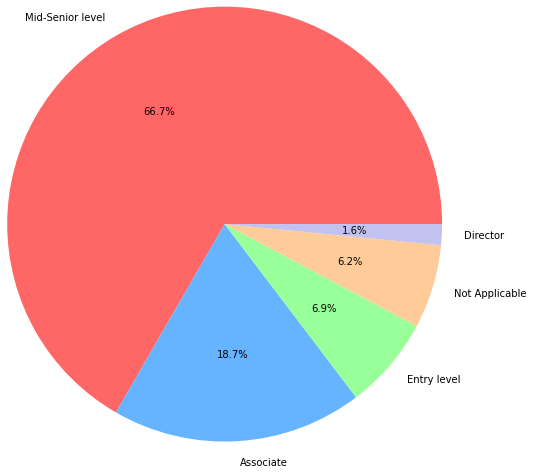

In [15]:
seniority_level_counts = df["seniority_level"].value_counts()

colors=['#ff6666','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6']
plt.pie(seniority_level_counts.values, labels= seniority_level_counts.index, radius=2.5, colors=colors, autopct='%1.1f%%')
None

Mid-senior level has the highest number of job postings with 66.7 percent and the least number of job postings have director as the position.



Also, it is useful to have a heatmap that represents the relation between seniority level, country and the salary. `plotly.express` package is used for this purpose. It has a simple function named `density_heatmap` which takes the DataFrame object and the names of the columns specifies X, Y and Z axises. Z axis is visualized by color range, while X and Y axises are visualized by rows and columns respectively.

In [16]:
fig = px.density_heatmap(df, y="country", x="seniority_level", z='norm_salary_average', histfunc = "avg")
fig.show()

In Australia and the UK, director salaries reach up to 90k. In the USA, mid-senior level can reach the same salary. Considering 4 countries, entry level has the lowest salary with an average of 40k.


Below, a donut chart is drawn to show the distribution of top 9 frequent industries in the whole data set. But before being able to do this, it is required to process "industry_list" column since the column is formed in string that contains multiple industry names separated by "," character and/or "and" word.

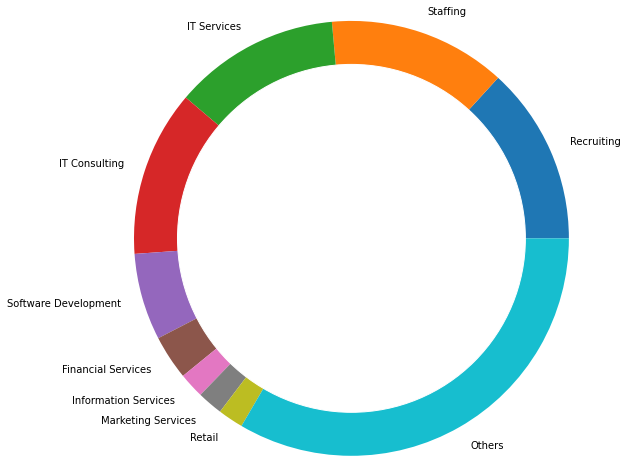

In [17]:
# Splitting the values in the "industries" column by ", and ", ", " or " and ". Sometimes the names are separated simply
#  with a comma but sometimes there are "and" instead of commas.
df["industry_list"] = df["industries"].astype(str).apply(lambda x: [i.strip() for i in re.split(r", and |, | and ", x)])

# Before having the frequencies per industry names, it is required to explode the rows on the "industry_list" column
#  since it holds a value in `List` of strings form.
industry_value_counts = df["industry_list"].explode().value_counts()
# There are too many industry names that is not less enough to show all of them. So it is better to just take
#  the most frequent 9 of them and take the rest of them in a separate slice.
top_industries = industry_value_counts[:9]
other_industries = industry_value_counts[9:]
# And it is required to sum the total number of the industries in "other_industries" slice to be able to add the
#  total number as a separate slice in the pie chart.
industry_counts = pd.concat([
    top_industries,
    pd.Series([other_industries.sum()], index = ["Others"]),
])
plt.pie(industry_counts.values, labels= industry_counts.index, radius=2.5)

# After drawing a simple pie chart, simply a circle filled with white color is drawn at the center of the pie to
#  make it looks like a donut.
my_circle=plt.Circle((0,0), 2, color='white', clip_on=False)
p=plt.gcf().gca().add_artist(my_circle)

plt.show()


The industries with the most amount of job postings, almost equally, are IT consulting, IT services, staffing and recruiting.

It would be nice to do the same things that we do above, for also the job function information of the records. Below another donut chart is drawn to visualize the distribution of the 7 top most frequent job functions in the data set.

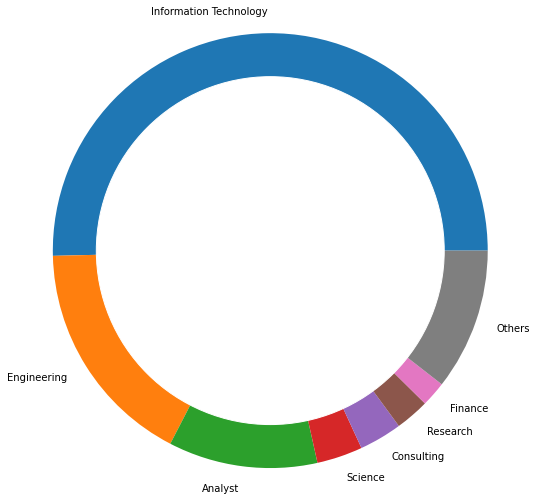

In [18]:
df["job_function_list"] = df["job_function"].astype(str).apply(lambda x: [i.strip() for i in re.split(r", and |, | and ", x)])

job_function_list_count = df["job_function_list"].explode().value_counts()
job_function_list_count_top = job_function_list_count[:7]
job_function_list_count_others = job_function_list_count[7:]
job_function_list_count_simple = pd.concat([
    job_function_list_count_top,
    pd.Series([job_function_list_count_others.sum()], index = ["Others"]),
])

plt.pie(job_function_list_count_simple.values, labels= job_function_list_count_simple.index, radius=2.5)

my_circle=plt.Circle((0,0), 2, color='white', clip_on=False)
p=plt.gcf().gca().add_artist(my_circle)

plt.show()

There are the highest number of job postings in information technology field. This position is followed by the engieering and analyst.



Below, a table is presented to list 3 companies that pays the higest salaries per each country. In the data set, the company name is given under the `subtitle` column.

The python code below is:
- sorting the rows by the salary in descending order,
- removes job postings duplicated for the same companies,
- grouping the sorted and de-duplicated rows by the countries,
- and taking first 3 rows for each group

in order.

In [19]:
df\
    .sort_values("norm_salary_average", ascending=False)\
    .drop_duplicates(["country", "subtitle"])\
    .groupby("country")\
    .head(3)\
    [["country", "subtitle", "norm_salary_average"]]\
    .set_index(["country", "subtitle"])

norm_salary_average
country        subtitle                                 
United States  VirtuousAI                       122100.0
               Harnham                          118400.0
               Mitchell Martin Inc.             118400.0
United Kingdom Propel                           115000.0
               Referment                        115000.0
               Bettor Believe                   115000.0
Australia      Clarrow                           94500.0
               Trigon Trading                    94500.0
               White Bay                         93150.0
Canada         Acerta                            78300.0
               Morgan McKinley                   72500.0
               Logikk                            72500.0

The company that offers the highest salary amount in the US is VirtuousAI, in the UK it is Propel, in Australia it is Clarrow and in Canada it is Acerta.


In the rest of this section, the information that is extracted from the description of job postings will be visualized. To be able to work on the description data, it is required to process it with Natural Language Processing methods first. For this purpose, NLTK package is used in this project. In the below python code, required sub modules of NLTK package are being downloaded to make all the required features are available to be used.

In [205]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('stopwords')
None

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/suheydaakbay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/suheydaakbay/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/suheydaakbay/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suheydaakbay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Below a function named `extract_phrases` is defined. This function takes a string parameter named "text". "text" parameters is being tokenized, grouped by noun tokens and used for creating ngrams to extract potential noun phrases. Every possible subsets of sequental tokens in the "text" are extracted to be processed later.

In [206]:
stopword_list = [str.upper(stopword) for stopword in stopwords.words('english')]

def extract_phrases(text):
    phrases = set()

    text = re.sub(r"[^A-Za-z\s]", " ", text) # Removing any character that is not a letter nor space character
    tokens = nltk.word_tokenize(text) # Split the text into tokens
    tokens = [token for token in tokens if not token in stopword_list] # Remove tokens that are in the stopword list
    tagged_tokens = nltk.pos_tag(tokens) # Tag the tokens
    chunks = nltk.RegexpParser("NounPhrase: {<N.*>+}").parse(tagged_tokens) # Group consecutive tokens with noun labels
    for chunk in chunks:
        if isinstance(chunk, nltk.tree.Tree): # Take only the noun groups
            words = [token[0] for token in chunk] # Each token is a tuple of the word and the label, take only the word
            ngrams = list(everygrams(words, max_len=4)) # Generate ngrams from the words of the group
            for ngram in ngrams:
                phrase = " ".join(ngram) # Convert ngram, which is a list of words, into strings by combining with space
                phrase = str.upper(phrase) # Normalize the phrase by converting into upper case
                phrases.add(phrase)

    return phrases


Below, the `extract_phrase` function is being applied to description text of each of the records. The phrase set extracted from the function is being stored as a new column named "phrases".

In [207]:
df["phrases"] = df["description"].apply(lambda x: extract_phrases(x))

Below, the phrases existing in the descriptions are weighted by a simple function before calculating the weighted frequencies. The formula is simply the square root of the words count in the phrase. With this simple weighting formula, it is possible to have phrases that are formed by multiple words placed upper places in the frequency list.

In [215]:
phrases_explode = df["phrases"].explode().to_frame() # Exploding rows per each phrase in the records
phrases_explode["weight"] = phrases_explode["phrases"].apply(lambda x: len(x.split()) ** 0.5) # Calculation weight for the phrases
phrases = phrases_explode.groupby("phrases").sum("weight").sort_values("weight", ascending=False)["weight"]
phrases

phrases
DATA          474.0
EXPERIENCE    470.0
TEAM          409.0
ROLE          373.0
BUSINESS      341.0
              ...  
CONSUMABLE      1.0
CONSUME         1.0
CONTENTION      1.0
CONTINUAL       1.0
AARON           1.0
Name: weight, Length: 47140, dtype: float64

A heatmap is created to compare some important technical skills with the 10 most common job function and salary amount sought in employee candidates.

*Note: The technical skills are explicitly choosen.*

In [209]:
# A few phrases are selected to compare with common job functions
selected_phrases = [
    "PYTHON", "SQL", "R", "MACHINE LEARNING", "TABLEAU", "EXCEL",
    "JAVA", "JAVASCRIPT", "NOSQL", "BIGQUERY", "NLP", "NUMPY",
    "KERAS", "GO", "AWS", "AZURE", "GOOGLE CLOUD", "POSTGRESQL",
]

# Top frequent 10 job functions are separated
top_job_functions = df["job_function_list"].explode().value_counts()[:10].index

# Explode rows for each phrase in the phrase list to be able to apply aggregations
phrases_and_job_functions = df[["job_function_list", "phrases", "norm_salary_average"]].explode("job_function_list").explode("phrases")
phrases_and_job_functions = phrases_and_job_functions[phrases_and_job_functions["phrases"].isin(selected_phrases)]

# Any other job function that is not one of the top frequent 10 will be replaced with "Other"
phrases_and_job_functions.loc[~phrases_and_job_functions["job_function_list"].isin(top_job_functions), "job_function_list"] = "Other"

px.density_heatmap(phrases_and_job_functions, y="job_function_list", x="phrases", z='norm_salary_average', histfunc = "avg")

The salary amount of job postings with Numpy, Google Cloud, NoSQL requirements and with Science keyword reaches up to 100k. The same amount meets Google Cloud in data analysis and PostgreSQL in finance. Also, it seems that candidates who know PostgreSQL and Keras in engineering position can have a salary of 90k. 

Below, top 100 most frequent phrases are shown with their frequencies in a bar chart.

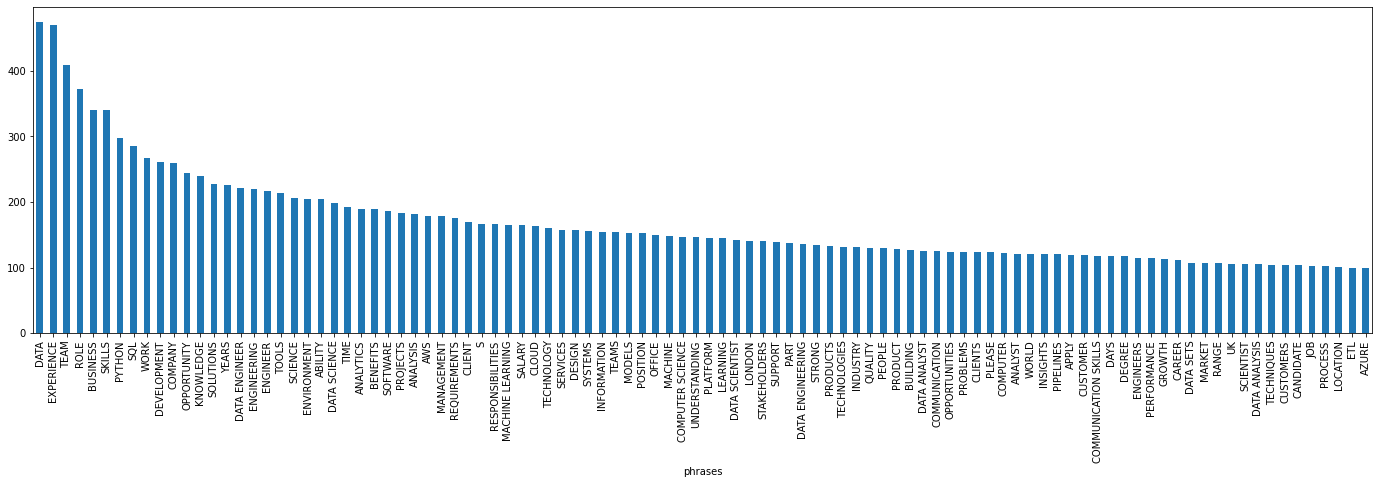

In [210]:
plt.figure(figsize=(24, 6))
plt.xticks(rotation='vertical')
phrases[0:100].plot(kind = "bar")
None

It can be seen that "Data", "Python" and "SQL" keywords are at the top places in job descriptions in job postings.

The most frequent 500 keyphrases are illustrated by wordcloud. The sizes of keyphrases vary according to the frequency of occurrence in job descriptions. Thanks to this workcloud, the required qualifications for the employee candidates in the job descriptions are visualized.

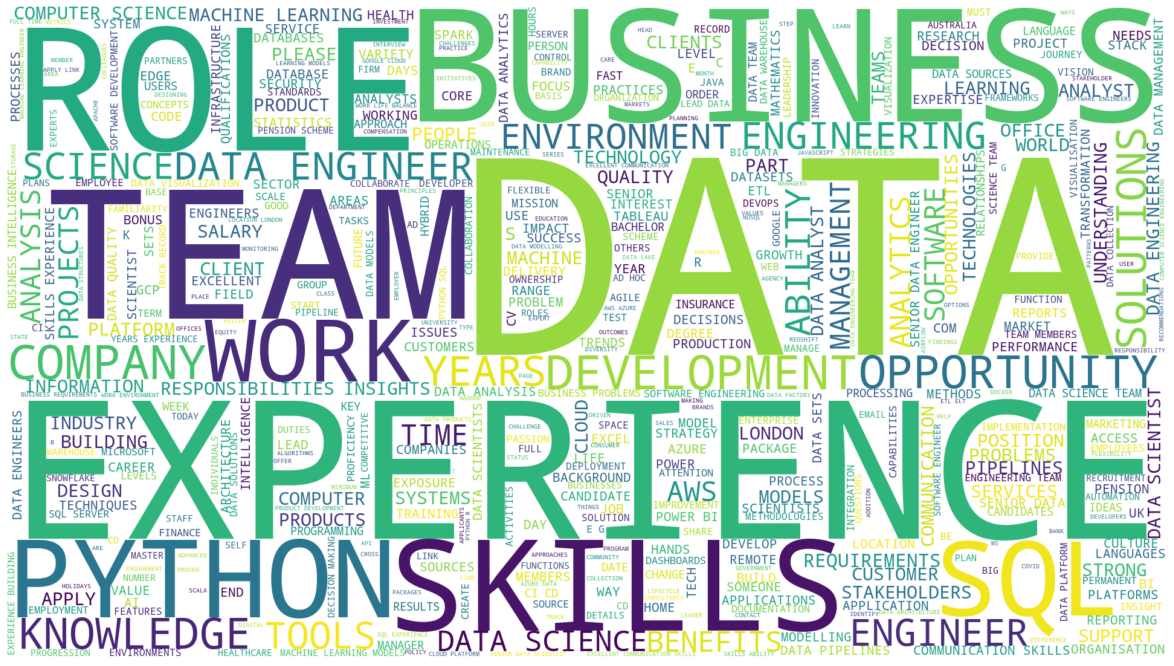

In [211]:
wc = WordCloud(background_color="white", max_words=500, width=1920, height=1080)
wc.generate_from_frequencies(phrases.to_dict())
plt.figure(figsize = (24,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## References

- Dataquest. (2021, March 30). Tutorial: Web Scraping with Python Using Beautiful Soup [Online]. Available: https://www.dataquest.io/blog/web-scraping-python-using-beautiful-soup/
- Digitalocean Community. (2017, July 14). How To Work with Web Data Using Requests and Beautiful Soup with Python 3 [Online]. Available: https://www.digitalocean.com/community/tutorials/how-to-work-with-web-data-using-requests-and-beautiful-soup-with-python-3
- Python Documantation. (2022, January 03). Errors and Exceptions [Online]. Available: https://docs.python.org/3/tutorial/errors.html
- Machine Learning Mastery. (2020, August 28). How to Handle Missing Data with Python [Online]. Available: https://machinelearningmastery.com/handle-missing-data-python/
- Python Documantation. (2022, January 01). Regular expression operations [Online]. Available: https://docs.python.org/3/library/re.html
- Plotly. Treemap Charts in Python [Online]. Available: https://plotly.com/python/treemaps/
- Plotly. 2D Histograms in Python [Online]. Available: https://plotly.com/python/2D-Histogram/
- Python Graph Gallery. Chart Types [Online]. Available: https://www.python-graph-gallery.com
- NLTK Documentation.(2021, December 28). Natural Language Toolkit [Online]. Available: https://www.nltk.org
- Guru99. (2022, January 1). NLTK Tutorial: What is NLTK Library in Python? [Online]. Available: https://www.guru99.com/nltk-tutorial.html